# Word2Vec
- This is an implementation of Mikolov's paper: Distributed Representations of Words and Phrases and their Compositionality with the intent of leveraging the output generated by the model as a Recommender System. In this notebook, the dataset used contains a set of items identified by numbers. Each number identifies a distinct item. The pairs of items on each row of the dataset identifies items that were searched and sometimes purchased within the same web session. 
- In word2vec, a representation is learned for words that co-occur. By co-occur, we mean items that appear in the same context. In this implementation of Word2Vec, we learn a representation for items that co-occur in the same web sessions. To make an analogy to Word2Vec: Context = Web Session & Words = Items.
- Word2Vec englobes two algorithms: CBOW (Continuous Bag of Words) and Skip-Gram. In this notebook, a Skip-Gram model is implemented.

## Skip-Model 
- In the Skip-Gram algorithm the goal is to predict the context word given a target word
- In the Vanilla version of the Skip-Gram model, the task is treated as a multi-class classification problem where:
    - <b> The input layer </b> consists of a one-hot enconding vector where its length is equal to the size of our vocabulary. In the context of learning a representation for items, the vocabulary is equivalent to our glossary/catalog of items available.
    - When multiplying the input layer (one-hot encoded vector) with the <b>The Embedding Matrix</b>, we extract a vector for the target word. The Embedding matrix acts as a lookup table for each vector.
    - This vector is then multiplied by the <b> Context Matrix </b>, for one target item, this can be seen as computing the dot product between this item and all other items in the vocabulary. Once properly trained, a higher dot product value will indicate a higher connection between these two items. In other words, they co-occured more often. After this multiplication, we end up with a vector of the size of our vocabulary. 
    - In the <b> Output Layer </b>, we apply the Softmax function to turn these values into probabilities.

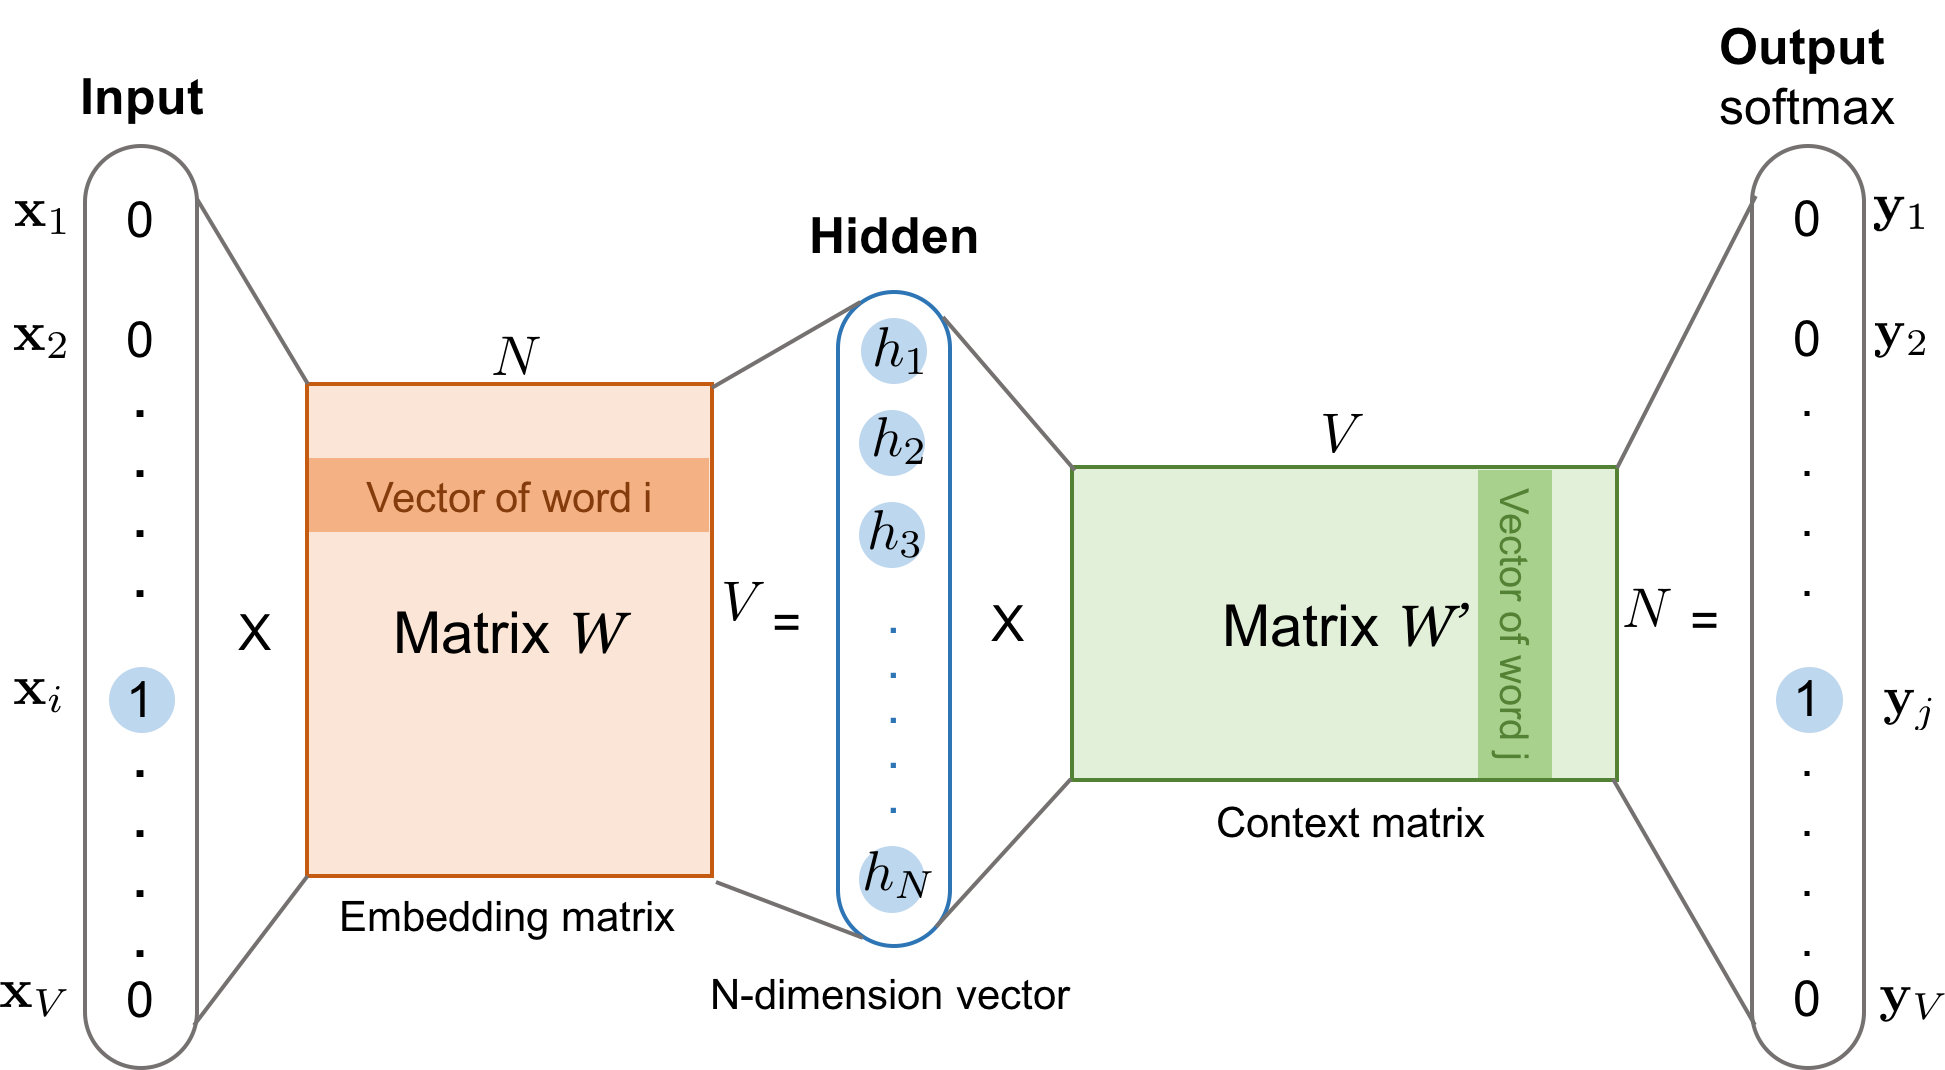

In [10]:
Image(filename = "./nn_structure_skip_gram_model.png", width=600, height=600)

### Negative Sampling
This description is the Vanilla version of the Skip-Gram model. This implementation of the algorithm does not work well in practice since it is computationally expensive to compute the softmax function for each batch of training data in the training phase. Instead, as mentioned in Mikolov's paper, we could either use an approximation of the full softmax called the Hierarchical softmax to reduce the computational cost or turn the task into a binary classification problem by generating <i>k</i> negative samples for each observed samples in our dataset. For it's simplicity, Negative Sampling was chosen to be implemented in this notebook. This method works in practice since we train the NN to distinguish between two real co-occurences versus two semi-random co-occurences.

### 1. Import Dataset
- The dataset should contain a set of input, output data
- There should be as many rows as occurence of these pairs of target, context items

In [1]:
import numpy as np
import pandas as pd
import os
from IPython.display import Image
from IPython.core.display import HTML 

import io
import re
import string
import tqdm
import pickle

from os import listdir
from os.path import isfile, join

import tensorflow as tf
from tensorflow.keras import layers
AUTOTUNE = tf.data.AUTOTUNE

from utils import *

In [50]:
"""
An example of the format is:
        input, output
        toad, amphibian
        frog, amphibian
        amphibian, toad
        amphibian, frog
        politics, paris
        paris, politics
        ...
        
In my example, I have encoded the items as numbers
"""

emb = pd.read_csv('df_sample.csv') # Import your dataset
emb = emb.sample(frac=1) # Shuffling the data to be able to shuffle a smaller size when creating the tensorflow dataset
print(len(emb))
emb.head()

2698928


,input,output
1301690,922,172
736268,922,265
1212010,922,970
1373414,1307,900
896903,799,1413


### 2. Data Processing

#### 2.1 Rare Word Pruning
- Removing certain pairs of target/context items because their occurence is low. These pairs of items that do not appear often enough will bring noise and the model will not learn a meaningful relationship between these items.
- Minimum number of words to learn a meaningful representation for the pair of context/target words

In [51]:
min_count_rare_word_pruning = 100
emb2 = prune_rare_words(emb, min_count_rare_word_pruning)
print(len(emb2))
emb2.head()

Using a treshold of 100: 0.0% of observations were pruned
2698928


,input,output
0,0,693
1,0,693
2,0,693
3,0,693
4,0,693


#### 2.2 Subsampling
- If we do not subsample certain pairs of items, we will work an unbalanced dataset. We will have a model that is overly focused on certain pairs of items. Instead, it's best to discard these pairs of items for which we have too many occurences. 

In [52]:
subsampling_treshold = 0.0002
emb3 = subsample(emb2, subsampling_treshold).sample(frac=1) # to make sure that we shuffle correctly
print(len(emb3))
emb3.head()

341762


,input,output
78736,317.0,528.0
275794,1143.0,1149.0
266472,1064.0,843.0
42373,246.0,265.0
41061,222.0,620.0


In [53]:
observed_items = emb3.values.flatten() # returns all observed items in a list 
vocab_size = len(set(observed_items)) # Will need to change that for number of distinct items in dataset
print(vocab_size)

50


In [54]:
vocab, inv_vocab = create_vocab(emb3)

In [55]:
emb3['input'] = emb3.input.apply(lambda x: vocab[x])
emb3['output'] = emb3.output.apply(lambda x: vocab[x])
emb3.head()

,input,output
78736,28,8
275794,47,49
266472,22,35
42373,46,5
41061,39,42


#### 2.3 Negative Sampling
- The Vanilla version of the Skip-Gram model does not work well in practice. It is extremely expensive to have to compute the softmax function for all words in the vocabulary/items in the catalog. Instead, one way to overcome this is to change the task from a multiclass classification problem to a binary classification problem. For each target word, we select <i>k</i> negative samples where the context word is selected according to a noise distribution.

More details about each of these function can be found in the paper.

In [105]:
"""
For example: item 0 and item 1 represents a true pair of items found in our dataset. 
We will generate 3 negative samples by selecting at random with a certain probability other items:

- input, output, y 
- 0, 1, 1
- 0, 2, 0
- 0, 4, 0
- 0, 7, 0
"""

k=5
pwr_val=1/4

neg_samp_df, targets, contexts, labels = generate_negative_samples(emb3.sample(frac=1), k, pwr_val)
targets_tf = tf.convert_to_tensor(targets)
contexts_tf = tf.convert_to_tensor(contexts)
labels_tf = tf.convert_to_tensor(labels)

In [57]:
## FREE UP MEMORY
del emb, emb2

### 3. Generate Tensorflow Tensors

In [59]:
# Just disables the warning, doesn't take advantage of AVX/FMA to run faster
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # this is to ignore the error message: assuming you are running on GPU it is not necessary to see the error message

BATCH_SIZE = 30  ### --> HYPER-PARAMETER TO FINE TUNE
BUFFER_SIZE = 10000
TRAIN_PERC = .9 # Percentage of samples in train

dataset = tf.data.Dataset.from_tensor_slices(((targets_tf, contexts_tf), labels_tf))
n_samples = len(list(dataset))
train_size = int(n_samples * TRAIN_PERC)
test_size = n_samples - train_size

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

print("Train Size: ", len(list(train_dataset)), "Test Size:", len(list(test_dataset)))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

Train Size:  307585 Test Size: 34177


In [60]:
filename_ = str(min_count_rare_word_pruning) + "_" + str(subsampling_treshold) + "_" + str(vocab_size) + "_" + str(k) + "_" + str(pwr_val)

### 4. The Model

### Add a section on Adam Optimization

- LEARNING_RATES: The learning rate of the optimizer
- EMBEDDING_DIMS: The dimension of the embeddings

In [62]:
EMBEDDING_DIMS = [5,6,7] #[10
LEARNING_RATES = [.001]

In [63]:
save_embeddings = True
for embedding_dim in EMBEDDING_DIMS: 
    for learning_rate in LEARNING_RATES: 

        train_loss_dict = {}
        train_accuracy_dict = {}
        test_results_dict = {}

        word2vec = Word2Vec(vocab_size, embedding_dim, k)

        opt = tf.keras.optimizers.Adam(
                learning_rate=learning_rate,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                amsgrad=False,
                name='Adam',
            )
            
        word2vec.compile(optimizer=opt,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
        
        # Callbacks
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
        es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                    min_delta=0.001,
                    patience=2,
                    mode='max',
                    restore_best_weights=True) 
        
        results = word2vec.fit(train_dataset, 
                                epochs=10, 
                                callbacks=[tensorboard_callback, es],
                                validation_data=test_dataset
                            )                     
        
        model_name = f"{str(embedding_dim)}-{str(learning_rate)}"
        train_loss_dict[model_name] = results.history["loss"]
        train_accuracy_dict[model_name] = results.history["accuracy"]
        
        test_results = word2vec.evaluate(test_dataset, callbacks=[tensorboard_callback])
        test_results_dict[model_name] = test_results 

        model_id = filename_ + '_EMB_DIM_' + str(embedding_dim) + "_LR_" + str(learning_rate)

        logs_dict = {model_id:{'loss':train_loss_dict, 
                        'accuracy':train_accuracy_dict,
                        'test':test_results_dict
                                    }
                    }

        # Saving as a pickle file
        local_path = './skip_gram_training_logs/' + model_id + '/'

        # if the path doesn't exist
        if not os.path.exists(local_path):
            os.makedirs(local_path)
        
        with open(local_path + 'logs_dict.pickle', 'wb') as handle:
            pickle.dump(logs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        print(model_name, "Test Loss", test_results[0], "Test Accuracy", test_results[1])

        if save_embeddings:
            weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
            df_embed = pd.DataFrame(weights, index=vocab.keys())

            with open(local_path + 'df_embed.pickle', 'wb') as handle:
                pickle.dump(df_embed, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/10
10252/10252 [==============================] - 12s 1ms/step - loss: 0.3662 - accuracy: 0.9058 - val_loss: 0.1984 - val_accuracy: 0.9270
Epoch 2/10
10252/10252 [==============================] - 11s 1ms/step - loss: 0.1894 - accuracy: 0.9296 - val_loss: 0.1879 - val_accuracy: 0.9287
Epoch 3/10
10252/10252 [==============================] - 14s 1ms/step - loss: 0.1856 - accuracy: 0.9296 - val_loss: 0.1870 - val_accuracy: 0.9294
Epoch 4/10
1139/1139 [==============================] - 1s 885us/step - loss: 0.1880 - accuracy: 0.9287
5-0.001 Test Loss 0.1879599690437317 Test Accuracy 0.9287386536598206
Epoch 1/10
10252/10252 [==============================] - 11s 1ms/step - loss: 0.3395 - accuracy: 0.9128 - val_loss: 0.1940 - val_accuracy: 0.9282
Epoch 2/10
10252/10252 [==============================] - 11s 1ms/step - loss: 0.1876 - accuracy: 0.9294 - val_loss: 0.1877 - val_accuracy: 0.9277
Epoch 3/10
10252/10252 [==============================] - 11s 1ms/step - loss: 0.1852 - acc

### 5. Visualization

### Add a section on cosine similarity

#### 5.1 Extracting the weights as the representation of our item

In [92]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
df_embed = pd.DataFrame(weights, index = vocab.keys())
df_embed.index = df_embed.index.astype(int).astype(str)
df_embed.to_csv("./df_embeddings.csv")

#### 5.2 Using cosine similarity to identify most similar items

In [93]:
import scipy.spatial as sp

df_embed.sort_index(inplace=True)
#computing the cosine between the items
cosines = 1 - sp.distance.cdist(df_embed.values, df_embed.values, 'cosine')

#creating a dataframe from the cosine
df_cosines = pd.DataFrame(cosines, columns = df_embed.index, index = df_embed.index)

df_cosines.head()

,0,1016,1024,104,1044,1064,1085,113,1143,1149,...,801,843,882,900,916,918,922,923,958,970
0,1.000000,-0.179694,-0.550086,-0.761748,-0.455697,0.047056,0.026907,-0.186893,0.068238,-0.405951,...,0.491805,-0.330699,0.011031,-0.440332,-0.537115,-0.447851,0.262245,0.273086,0.646168,0.175818
1016,-0.179694,1.000000,0.210466,0.432494,-0.063091,-0.418049,0.149768,0.999928,-0.607989,-0.057850,...,-0.401600,0.540393,0.255535,-0.078993,-0.388288,-0.068592,0.289697,-0.388918,-0.295232,-0.366808
1024,-0.550086,0.210466,1.000000,0.374160,-0.311959,-0.474904,0.187449,0.219032,0.189655,0.337302,...,-0.396782,0.715417,-0.346482,-0.329246,0.383749,-0.317004,-0.480472,-0.567409,-0.340935,-0.343331
104,-0.761748,0.432494,0.374160,1.000000,0.397086,-0.331633,0.465520,0.436717,-0.065275,0.284987,...,-0.542684,0.321466,-0.319208,0.391498,0.467739,0.389218,0.221026,0.036478,-0.934996,-0.452998
1044,-0.455697,-0.063091,-0.311959,0.397086,1.000000,0.373983,0.063309,-0.064850,-0.094470,0.327979,...,0.172992,-0.369894,0.211554,0.999527,0.335488,0.999885,0.171301,0.256277,-0.171632,-0.163779


In [97]:
# getting the top 10 most similar items for each item
big_arr = []
for row in df_cosines.iterrows():
    
    top10 = row[1].nlargest(10)
    
    for i in range(0, len(top10.values)):
        big_arr.append([top10.name, top10.values[i], top10.index.values[i]])
    
    
df_similarity = pd.DataFrame(big_arr, columns=['item', 'cosine', 'similar_item'])
df_similarity.head()

,item,cosine,similar_item
0,0,1.000000,0
1,0,0.646168,958
2,0,0.539889,246
3,0,0.491805,801
4,0,0.486924,300


In [100]:
# to find other similar items
df_similarity[df_similarity.item=='0']

,item,cosine,similar_item
0,0,1.000000,0
1,0,0.646168,958
2,0,0.539889,246
3,0,0.491805,801
4,0,0.486924,300
5,0,0.396434,732
6,0,0.379946,150
7,0,0.319913,562
8,0,0.273086,923
9,0,0.262245,922


#### 5.3 Extracting the representation for each item to display them in the embedding projector
- https://projector.tensorflow.org/

In [101]:
weights = {}

for idx, row in df_embed.iterrows():
    weights[idx] = row.values

In [102]:
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

In [103]:

for key, val in weights.items(): # for index, word in enumerate(vocab):
  vec = weights[key]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(key + "\n")
out_v.close()
out_m.close()

### 6. Additional steps performed not displayed in the notebook
1. Evaluation of the best model by looking at precision and recall for the different models generated. By different models, I mean the ones that are generated based on the different hyper-parameters (embedding size, learning rate, number of negative samples, subsampling rate, etc.)
2. Comparison to other benchmarks